PDB | https://rcsb.org

## 구조 데이터(structure data)란?

- 분자의 구조를 나타내는 파일 형식
- pdb, sdf, mol2, mmcif 등등 다양한 포맷이 존재
- 포맷마다 양식이 조금씩 다르지만 핵심은 원자마다 x, y, z 좌표 형태로 나타내는 것
- 단백질의 구조는 매우 복잡 --> 주로 pdb (legacy) 파일이나 mmcif (fancy) 파일로 저장됨

## 단백질 구조 파일 (PDBx/mmCIF) 이해하기
왜 PDXc/mmcif 인가?
- legacy pdb 포맷은 저장할 수 있는 원자의 갯수 제한이 있음(고정 열 기반) -> 이와 상관없이 활용되는 mmcif 포맷이 권장됨
- 최근 deposit되는 구조들의 경우에는 mmcif로만 제공되는 경우도 있음.

분석하고 싶은 단백질을 골라서 mmcif 파일로 다운로드한 뒤 현재 디렉토리에 위치시키고 살펴봅시다.

규칙
- 항상 data_ 로 시작하여 그 뒤에는 데이터 블록이 위치
- \# 으로 시작하는 줄은 주석 -> 기계가 읽지 않음
- 기록할 데이터 항목을 키-밸류 쌍으로 표현함

    `_category.item_name  value`
- 반복되는 데이터를 표현하고자 하는 경우 이들을 루프로 묶어서 반복 표현
    ```
    data_4HHB
    #
    _entry.id   4HHB
    _audit.creation_date 1984-07-28
    _audit.update_record 'Initial release'
    #
    loop_
    _audit_author.name
    _audit_author.pdbx_ordinal
    'G.FERMI' 1
    'M.F.PERUTZ' 2
    #
    _citation.id primary
    _citation.title 
    ;"THE CRYSTAL STRUCTURE OF HUMAN DEOXYHAEMOGLOBIN AT 1.74 
    ANGSTROMS RESOLUTION"
    ;
    ```

    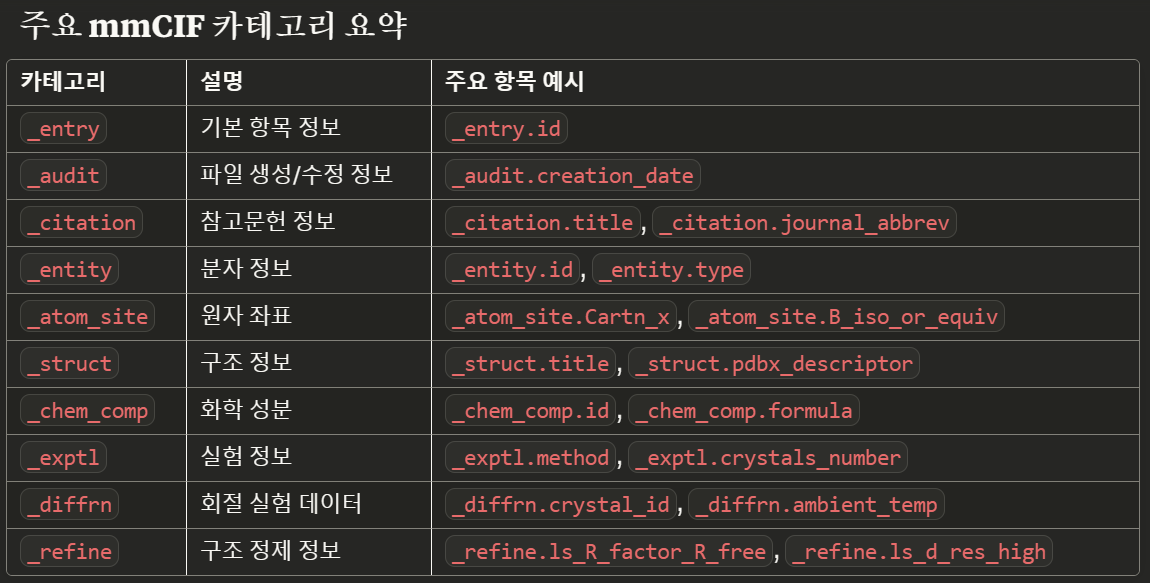

## RCSB API를 이용해서 데이터 검색 및 다운로드
- 크게 원하는 조건의 데이터 엔트리를 검색하는 search API와, 특정 엔트리에 대한 정보를 가져오는 data API로 구분


In [1]:
# search API 실습
import requests
import json

# query를 rcsb에서 복사해서 가져올 때는 따옴표(') 로 감싸서 string으로 만든 다음 json.loads() 함수 활용해서 parsing
built_query = '{"query":{"type":"terminal","label":"text","service":"text","parameters":{"attribute":"exptl.method","operator":"exact_match","negation":false,"value":"X-RAY DIFFRACTION"}},"return_type":"entry","request_options":{"paginate":{"start":0,"rows":25},"results_content_type":["experimental"],"sort":[{"sort_by":"score","direction":"desc"}],"scoring_strategy":"combined"}}'
built_query = json.loads(built_query)

def search_rcsb(query):
    response = requests.post(
        "https://search.rcsb.org/rcsbsearch/v2/query",
        json=query,
        headers={"Content-Type": "application/json"}
    )
    response.raise_for_status()
    return response.json()

response = search_rcsb(query=built_query)
response

{'query_id': '502e2f7e-fec7-469a-add0-b7d9a76a047b',
 'result_type': 'entry',
 'total_count': 194605,
 'result_set': [{'identifier': '100D', 'score': 1.0},
  {'identifier': '101D', 'score': 1.0},
  {'identifier': '101M', 'score': 1.0},
  {'identifier': '102D', 'score': 1.0},
  {'identifier': '102L', 'score': 1.0},
  {'identifier': '102M', 'score': 1.0},
  {'identifier': '103L', 'score': 1.0},
  {'identifier': '103M', 'score': 1.0},
  {'identifier': '104L', 'score': 1.0},
  {'identifier': '104M', 'score': 1.0},
  {'identifier': '105M', 'score': 1.0},
  {'identifier': '106M', 'score': 1.0},
  {'identifier': '107L', 'score': 1.0},
  {'identifier': '107M', 'score': 1.0},
  {'identifier': '108L', 'score': 1.0},
  {'identifier': '108M', 'score': 1.0},
  {'identifier': '109D', 'score': 1.0},
  {'identifier': '109L', 'score': 1.0},
  {'identifier': '109M', 'score': 1.0},
  {'identifier': '10GS', 'score': 1.0},
  {'identifier': '10MH', 'score': 1.0},
  {'identifier': '110D', 'score': 1.0},
  {'

In [2]:
# Data API 실습

# 1. MMCIF contents를 string으로써 변수에 저장하고 싶다면: url requests
def get_response(url, r_type='json'):
    response = requests.get(url)
    if response.status_code == 200:
        if r_type=='json':
            result = response.json()
        elif r_type=='text':
            result = response.text
    else:
        raise ConnectionError(f"Error: {response.status_code} while treating query {url}")
    return result

url = "https://files.rcsb.org/view/5M3B.cif"
mmcif_string = get_response(url, r_type="text")

# 2. MMCIF contents를 file로써 특정 위치에 저장하고 싶다면: Biopython 활용 (또는 위 string 직접 저장)
from Bio.PDB import *
pdbl = PDBList(server='ftp://ftp.pdbj.org') # PDBj 서버 (EBI 서버: ftp://ftp.ebi.ac.uk)
pdbl.retrieve_pdb_file('4hhb', pdir='./mmcifs', file_format='mmCif')

Structure exists: './mmcifs/4hhb.cif' 


'./mmcifs/4hhb.cif'

mmcif 파일 구성

- 보통 하나의 data container == pdb entry
- data category: 같은 대상에 대한 데이터 아이템을 그룹화 (_atom_site 등)
- data item: 데이터 카테고리 내의 개별 필드 -> 하나의 값을 가짐


**Biopython mmcif parser 사용법**

- 기본적으로 SMCRA hierarchy을 사용
    - Structure
    - Model
    - Chain
    - Residue
    - Atom

- `Bio.PDB.MMCIFParser`

In [ ]:
# 파일 정보 탐색 (key-value 방식)
from Bio.PDB.MMCIF2Dict import MMCIF2Dict

mmcif_dict = MMCIF2Dict("./mmcifs/5m3b.cif")

print(mmcif_dict.keys())

print(mmcif_dict.get("_entity.id"))

def get_data_category(mmcif_dict, data_category):
    match_keys = [k for k in mmcif_dict.keys() if k.startswith(data_category)]
    if not match_keys:
        print(f"data catogory {data_category} 를 찾을 수 없습니다")
        return {}
    
    return {k:mmcif_dict[k] for k in match_keys}

get_data_category(mmcif_dict, "_atom_site")

dict_keys(['data_', '_entry.id', '_audit_conform.dict_name', '_audit_conform.dict_version', '_audit_conform.dict_location', '_database_2.database_id', '_database_2.database_code', '_database_2.pdbx_database_accession', '_database_2.pdbx_DOI', '_pdbx_audit_revision_history.ordinal', '_pdbx_audit_revision_history.data_content_type', '_pdbx_audit_revision_history.major_revision', '_pdbx_audit_revision_history.minor_revision', '_pdbx_audit_revision_history.revision_date', '_pdbx_audit_revision_details.ordinal', '_pdbx_audit_revision_details.revision_ordinal', '_pdbx_audit_revision_details.data_content_type', '_pdbx_audit_revision_details.provider', '_pdbx_audit_revision_details.type', '_pdbx_audit_revision_details.description', '_pdbx_audit_revision_details.details', '_pdbx_audit_revision_group.ordinal', '_pdbx_audit_revision_group.revision_ordinal', '_pdbx_audit_revision_group.data_content_type', '_pdbx_audit_revision_group.group', '_pdbx_audit_revision_category.ordinal', '_pdbx_audit_rev

{'_atom_sites.entry_id': ['5M3B'],
 '_atom_sites.fract_transf_matrix[1][1]': ['0.007338'],
 '_atom_sites.fract_transf_matrix[1][2]': ['0.000000'],
 '_atom_sites.fract_transf_matrix[1][3]': ['0.002778'],
 '_atom_sites.fract_transf_matrix[2][1]': ['0.000000'],
 '_atom_sites.fract_transf_matrix[2][2]': ['0.011055'],
 '_atom_sites.fract_transf_matrix[2][3]': ['0.000000'],
 '_atom_sites.fract_transf_matrix[3][1]': ['0.000000'],
 '_atom_sites.fract_transf_matrix[3][2]': ['0.000000'],
 '_atom_sites.fract_transf_matrix[3][3]': ['0.021044'],
 '_atom_sites.fract_transf_vector[1]': ['0.00000'],
 '_atom_sites.fract_transf_vector[2]': ['0.00000'],
 '_atom_sites.fract_transf_vector[3]': ['0.00000'],
 '_atom_site.group_PDB': ['ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
  'ATOM',
 

In [22]:
# 파서를 사용해서 sturcture 객체 생성
from Bio.PDB import MMCIFParser

parser = MMCIFParser(QUIET=True)
structure = parser.get_structure("5m3b", "./mmcifs/5m3b.cif")

print(f"구조 ID: {structure.id}")
print(f"모델 수: {len(structure)}") # X-ray 구조는 대부분 1개. NMR 구조의 경우 모델의 수가 2개 이상인 경우가 많음.

구조 ID: 5m3b
모델 수: 1


In [27]:
# Biopython 구조 탐색
for model in structure:
    print(f"\n모델 ID: {model.id}")
    for chain in model:
        print(f"\n체인 ID: {chain.id}")
        for residue in chain:
            print(f"\n잔기 정보: {residue.resname} {residue.id[1]} {residue.segid}")
            for atom in residue:
                print(f"원자 정보: {atom.name} {atom.element} {atom.coord}")
                pass


모델 ID: 0

체인 ID: A

잔기 정보: ALA 23  

잔기 정보: PRO 24  

잔기 정보: ARG 25  

잔기 정보: VAL 26  

잔기 정보: ILE 27  

잔기 정보: THR 28  

잔기 정보: LEU 29  

잔기 정보: SER 30  

잔기 정보: PRO 31  

잔기 정보: ALA 32  

잔기 정보: ASN 33  

잔기 정보: THR 34  

잔기 정보: GLU 35  

잔기 정보: LEU 36  

잔기 정보: ALA 37  

잔기 정보: PHE 38  

잔기 정보: ALA 39  

잔기 정보: ALA 40  

잔기 정보: GLY 41  

잔기 정보: ILE 42  

잔기 정보: THR 43  

잔기 정보: PRO 44  

잔기 정보: VAL 45  

잔기 정보: GLY 46  

잔기 정보: VAL 47  

잔기 정보: SER 48  

잔기 정보: SER 49  

잔기 정보: TYR 50  

잔기 정보: SER 51  

잔기 정보: ASP 52  

잔기 정보: TYR 53  

잔기 정보: PRO 54  

잔기 정보: PRO 55  

잔기 정보: GLN 56  

잔기 정보: ALA 57  

잔기 정보: GLN 58  

잔기 정보: LYS 59  

잔기 정보: ILE 60  

잔기 정보: GLU 61  

잔기 정보: GLN 62  

잔기 정보: VAL 63  

잔기 정보: SER 64  

잔기 정보: THR 65  

잔기 정보: LEU 66  

잔기 정보: GLN 67  

잔기 정보: GLY 68  

잔기 정보: MET 69  

잔기 정보: ASN 70  

잔기 정보: LEU 71  

잔기 정보: GLU 72  

잔기 정보: ARG 73  

잔기 정보: ILE 74  

잔기 정보: VAL 75  

잔기 정보: ALA 76  

잔기 정보: LEU 77  

잔기 정보: LYS 78  

잔기 정보: PRO 79  

잔기 정보: ASP

In [ ]:
# Iterate over all atoms in a structure
for atom in structure.get_atoms():
    print(atom)

# Iterate over all residues in a model
for residue in model.get_residues():
    print(residue)
    
    
residue = atom.get_parent()
chain = residue.get_parent()


# Get all residues from a structure
res_list = Selection.unfold_entities(structure, "R")
# Get all atoms from a chain
atom_list = Selection.unfold_entities(chain, "A")


model = structure[0]
chain = model["A"]
residue = chain[100]
atom = residue["CA"]

In [ ]:
## 그 외 권장되는 mmcif parser들
# pip install pdbecif
# pip install gemmi
# pip install mmcif (wwPDB 공식 파서)